Post process 3D bbx tracking data produced in April 2021
Goals
1. rectify 3D bbox measurements into comprehensible trajecotry data for enhancing training
2. manual validate the rectified measurements with the videos

Tasks
1. compute homography matrix (done)
2. transform bottom 4 poitns into real-world coords (done)
3. work on the road plane (done, but dimensions seem incorrect)
4. use optimization to rectify measurements (see 3)
5. add motion (velocity. acceleration) constraints in optimization (done)
6. optimization switch direction south/north bound
6. Apply Joint Probabilistic Data Association algorithm (JPDA)
    https://stonesoup.readthedocs.io/en/latest/auto_tutorials/08_JPDATutorial.html
    a. one object has 4 measurements

In [3]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd

In [4]:
data_path = pathlib.Path().absolute().joinpath('2D to 3D conversion Examples April 2021')
file_name = data_path.joinpath('record_p1c4_00000_track_outputs_3D.csv')
df = utils.read_data(file_name)
df = df.rename(columns={'bbrx': 'bblx', 'bblx': 'bbrx', 'fblx': 'fbrx', 'fbrx': 'fblx',
                       'bbry': 'bbly', 'bbly': 'bbry', 'fbly': 'fbry', 'fbry': 'fbly'})
path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
# df = df.interpolate(method='nearest', axis=0)
df = utils.calc_rr_coords(df, 'P1C4', path_vpts) # P1C4 good
fps = 30
df = utils.calc_timestamp(df,fps)
df = df.dropna()
# A = [36.004184, -86.608820] # a line that's parallel to the lanes (from google map) north east side
# B = [36.003894, -86.608499]
A = [36.003945, -86.609184] # south west side, so that x, y coords obey counterclockwise
B = [36.003487, -86.608674]
df = utils.calc_xy(df,A,B)
df.head()

,Frame #,Timestamp,ID,Object class,BBox xmin,BBox ymin,BBox xmax,BBox ymax,vel_x,vel_y,...,bbllat,bbllon,fbr_y,fbl_y,bbr_y,bbl_y,fbr_x,fbl_x,bbr_x,bbl_x
0,0,0.000000,0,sedan,666.856689,33.981285,940.178589,166.329102,0.000000,0.000000,...,36.003928,-86.608686,31.167885,31.945320,31.165814,32.049670,33.671745,33.539229,31.491278,31.402403
1,0,0.000000,1,midsize,3448.115967,1003.948608,3837.037842,1191.645874,0.000000,0.000000,...,36.003718,-86.608598,21.362175,22.366559,21.331074,22.278672,56.846733,56.414848,54.316304,54.016995
2,0,0.000000,2,midsize,3480.558105,217.107834,3816.065430,368.470154,0.000000,0.000000,...,36.003762,-86.608532,29.265060,29.999846,29.257711,29.954542,56.944030,56.638139,54.628232,54.392115
3,0,0.000000,3,pickup,1114.203491,1546.007324,1655.062378,1763.902344,0.000000,0.000000,...,36.003795,-86.608755,16.405115,17.616302,16.344978,17.539169,41.817614,41.560797,38.420222,38.181647
4,1,0.033333,0,sedan,584.860107,37.387432,871.633301,166.026108,-81.996582,3.406147,...,36.003911,-86.608680,32.072354,31.160570,31.978507,31.162660,30.813207,30.903416,32.957110,33.092248


In [5]:
# Y1: semi40 Y2: semi 72
Y1 = df.loc[(df['ID']==42)]
Y1 = Y1.dropna()
timestamps = Y1['Timestamp'].values

In [6]:
# Y1['Timestamp'].values[-1]-Y1['Timestamp'].values[0]
(Y1['fbr_x'].values[-1]-Y1['fbr_x'].values[0])/(Y1['Timestamp'].values[-1]-Y1['Timestamp'].values[0])

19.563307080590143

In [7]:
lat1, lon1 = A
lat2, lon2 = B
pt = 'bbl'
pt_lats = np.array(Y1[[pt+'lat']])
pt_lons = np.array(Y1[[pt+'lon']])
toA = utils.haversine_distance(lat1, lon1, pt_lats, pt_lons)
toAB = utils.pt_to_line_dist_gps(lat1, lon1, lat2, lon2, pt_lats, pt_lons)
x = np.sqrt(toA**2-toAB**2)

In [8]:
import utils
importlib.reload(utils)
AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
utils.draw_map_box(Y1,Y1['fbrlat'].values[0],Y1['fbrlon'].values[0], 30, lats, lngs)


###############################

 Beginning Key Insertion ...

Key Insertion Completed!!


In [9]:
# time = Y1['Timestamp']
Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

In [10]:
dt = np.gradient(timestamps)
theta0 = utils.calc_theta(Y1, timestamps)
thetadot = np.gradient(theta0)/dt
_,_,v = utils.calc_vel(Y1,timestamps)
tan_phi = thetadot*l/v
phi = np.arctan(tan_phi)
np.degrees(theta0)

NameError: name 'l' is not defined

In [ ]:
# optimize on the road plane
# returns sigular matrix (constraints not continuous) if using equality constraints
import time

start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1


lam = 0.001 # regularize acceleration
lam2 = 0.0001 # regularize jerk
global lam, lam2, dt, Y1, timestamps

def obj(X):
    """The cost function"""   
#     global Yre, w, l
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
#     
    # min perturbation
    c1 = LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(Yre[:,0])
    v = dx/dt
    a = np.gradient(v)/dt
    c2 = lam * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam2 * LA.norm(j,2)
    return c1 + c2 + c3

def const1(X):
    # l, l, w, w, squared
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2)
#     return (Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2
          
def const2(X):
    # rectangle shape constraint
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]])**2)
#     return (Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]]).flatten('F')
                  
def const3(X):
    # follow straight lines movement and widthes are parallel to lanes
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.1 - np.std(Yre[:,3]) - np.std(Yre[:,1]) - np.std(Yre[:,5]) - np.std(Yre[:,7])
#     return np.std(Yre[:,3]) + np.std(Yre[:,1]) + np.std(Yre[:,5]) + np.std(Yre[:,7])


nlc = ({"type": "ineq", "fun": const1},
       {"type": "ineq", "fun": const2},
       {"type": "ineq", "fun": const3})
Y1f = Y1.flatten('F')
X0 = np.append(Y1f,[2.2, 4])
bnds = [(0,np.inf) for i in range(0,len(X0)-2)]+[(1,3),(2,np.inf)]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':1000})
end = time.time()
print(end - start)

X_data = res.x[:-2]
w = res.x[-2]
l = res.x[-1]
Yre = np.reshape(X_data,(-1,len(Y1))).T

print(w,l)


In [ ]:
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
import time
start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1

dt = np.gradient(timestamps)
lam1 = 1000
lam2 = 100 # regularize acceleration
lam3 = 10 # regularize jerk
lam4 = 10 # regularize on thetaddot
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function"""    
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]

    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2
    
    # min perturbation
    c1 = lam1*LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    v = np.sqrt(vx**2+vy**2)
    
    a = np.gradient(v)/dt
    c2 = lam2 * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam3 * LA.norm(j,2)
    
    # theta ddot regularization
    thetaddot = np.gradient(np.gradient(theta)/dt)/dt
    c4 = lam4 * LA.norm(thetaddot,2)
#     print(c1,c2,c3,c4)
    return c1 + c2 + c3 +c4

def const4(X):
    # rectangle shape constraint using theta
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    sos = np.sum((cx + w/2*sin(theta) - Yre[:,0])**2)\
        + np.sum((cy - w/2*cos(theta) - Yre[:,1])**2)\
        + np.sum((Yre[:,0]+l*cos(theta)-Yre[:,2])**2)\
        + np.sum((Yre[:,1]+l*sin(theta)-Yre[:,3])**2)\
        + np.sum((Yre[:,2]-w*sin(theta)-Yre[:,4])**2)\
        + np.sum((Yre[:,3]+w*cos(theta)-Yre[:,5])**2)\
        + np.sum((Yre[:,0]-w*sin(theta)-Yre[:,6])**2)\
        + np.sum((Yre[:,1]+w*cos(theta)-Yre[:,7])**2)

    return 0.0001-sos

def const5(X):
    # Pfaffian constraint
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    c5 = -vx*sin(theta)+vy*cos(theta)
    return 0.001-np.sum(c5**2)

nlc = ({"type": "ineq", "fun": const4},
      {"type": "ineq", "fun": const5})

Y1f = Y1.flatten('F')
theta0 = np.zeros((N))
X0 = np.concatenate((Y1f, [1.1, 3],theta0), axis=0)
bnds = [(0,np.inf) for i in range(0,8*N)]+[(1,3),(2,np.inf)]+[(-np.pi/4,np.pi/4) for i in range(len(theta0))]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':2000})
end = time.time()
print(end - start)

X_data = res.x[:8*N]
w = res.x[8*N]
l = res.x[8*N+1]
theta = res.x[8*N+2:]
#     theta = X[8*N+2:]
Yre = np.reshape(X_data,(-1,N)).T
# theta = utils.calc_theta(Yre, timestamps)
print(w,l)


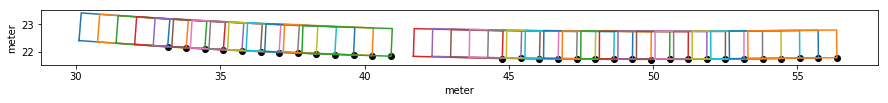

In [68]:
import mplcursors
import matplotlib.pyplot as plt
# right side
# startr = np.array([36.004563, -86.609610])
# endr = np.array([36.004381, -86.609340])
# # left side
# startl = np.array([36.004348, -86.609328])
# endl = np.array([36.004485, -86.609530])

D = Yre
fig, ax = plt.subplots(figsize=(15,1))
# %pylab

mplcursors.cursor(hover=True)

for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)

plt.scatter(D[:,2],D[:,3],color='black')
# plt.scatter(cx,cy)
# plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')

ax = plt.gca()
plt.xlabel('meter')
plt.ylabel('meter')
ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show() 

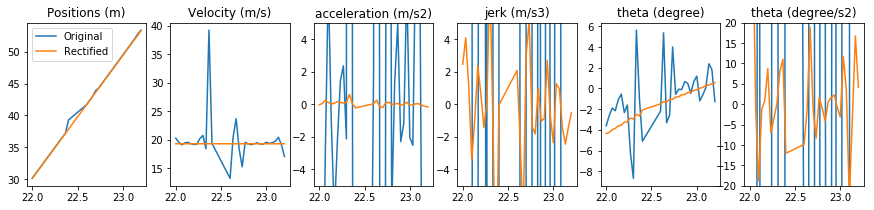

In [76]:
import utils
importlib.reload(utils)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15,3))

ax1.plot(timestamps, Y1[:,0], label='Original')
ax1.plot(timestamps, Yre[:,0] , label='Rectified')
ax1.legend()
ax1.set_title('Positions (m)')
    
_,_,v1 = utils.calc_vel(Y1, timestamps)
_,_,vre = utils.calc_vel(Yre,timestamps)
ax2.plot(timestamps, v1, label='Original velocity')
ax2.plot(timestamps, vre , label='Rectified velocity')
ax2.set_title('Velocity (m/s)')

a1 = utils.calc_accel(Y1[:,0], timestamps)
are = utils.calc_accel(Yre[:,0],timestamps)
ax3.plot(timestamps, a1, label='Original accel')
ax3.plot(timestamps, are , label='Rectified accel')
ax3.set_title('acceleration (m/s2)')
ax3.set_ylim([-5,5])

ax4.plot(timestamps, np.gradient(a1)/dt)
ax4.plot(timestamps, np.gradient(are)/dt)
ax4.set_title('jerk (m/s3)')
ax4.set_ylim([-5,5])

theta1 = utils.calc_theta(Y1, timestamps)
thetare = utils.calc_theta(Yre,timestamps)
ax5.plot(timestamps, np.degrees(theta1))
ax5.plot(timestamps, np.degrees(thetare))
ax5.set_title('theta (degree)')

thetaddot1 = np.gradient(np.gradient(theta1)/dt)/dt
thetaddotre = np.gradient(np.gradient(thetare)/dt)/dt
ax6.plot(timestamps, np.degrees(thetaddot1))
ax6.plot(timestamps, np.degrees(thetaddotre))
ax6.set_title('thetaddot (degree/s2)')
ax6.set_ylim([-20,20])
plt.show()

In [55]:
w=1
l=2
cx = (Y1[:,0]+Y1[:,6])/2
cy = (Y1[:,1]+Y1[:,7])/2
thetat = -np.ones((len(Y1)))*0.5
# thetat = utils.calc_theta(Y,timestamps)
# thetat = -theta
xa = cx+w/2*sin(thetat)
ya = cy-w/2*cos(thetat)
xb = xa+l*cos(thetat)
yb = ya+l*sin(thetat)
xc = xb-w*sin(thetat)
yc = yb+w*cos(thetat)
xd = xa-w*sin(thetat)
yd = ya+w*cos(thetat)

Y = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1)

In [ ]:
dim = utils.haversine_distance(Y1gps[:,4],Y1gps[:,5],Y1gps[:,2],Y1gps[:,3])
print(np.mean(dim), np.std(dim))

In [ ]:
# histogram of distance _y
n, bins, patches = plt.hist(x=Yre[:,2]-Yre[:,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# one-step ahead prediction from Y2 using vx and vy
def one_step_predict(Y, vx, vy, fps):
    Y2pred = Y.copy()
    Y2pred[:,[0,2,4,6]] = Y[:,[0,2,4,6]] + vx*1/fps
    Y2pred[:,[1,3,5,7]] = Y[:,[1,3,5,7]] + vy*1/fps
    return Y2pred

In [ ]:
# in lat/long per second
vx = (Y1.loc[Y1.index[-1]].bbrlat - Y1.loc[Y1.index[0]].bbrlat)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
vy = (Y1.loc[Y1.index[-1]].bbrlon - Y1.loc[Y1.index[0]].bbrlon)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
print(vx, vy)
Y3pred = one_step_predict(Y3, vx, vy, fps)